In [1]:
import segregation

In [34]:
import time

In [4]:
import geopandas as gpd
import libpysal

# Comparing the Dissimilarity 

In [5]:
from segregation.dissimilarity import Dissim

In [201]:
"""
Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Dissim']


def _dissim(data, group_pop_var, total_pop_var):
    """
    Calculation of Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    t = np.array(data.total_pop_var)
    g = np.array(data.group_pop_var)
    
    T = t.sum()
    P = g.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, g/t)
    
    D = (((t * abs(pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return D, core_data


class Dissim_Numpy:
    """
    Classic Dissimilarity Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
        
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
        
    Examples
    --------
    In this example, we will calculate the degree of dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> dissim_index = Dissim(df, 'nhblk10', 'pop10')
    >>> dissim_index.statistic
    0.31565682496226544
    
    The interpretation of this value is that 31.57% of the non-hispanic black population would have to move to reach eveness in the Riverside County.
        
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _dissim(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _dissim

In [1095]:
%%time
s_map = gpd.read_file(libpysal.examples.get_path("sacramentot2.shp"))
df = s_map[['geometry', 'HISP_', 'TOT_POP']]
index1 = Dissim(df, 'HISP_', 'TOT_POP')

Wall time: 46.9 ms


In [212]:
%%time
s_map = gpd.read_file(libpysal.examples.get_path("sacramentot2.shp"))
df = s_map[['geometry', 'HISP_', 'TOT_POP']]
index2 = Dissim_Numpy(df, 'HISP_', 'TOT_POP')

Wall time: 47.9 ms


In [213]:
s_map = gpd.read_file(libpysal.examples.get_path("sacramentot2.shp"))
df = s_map[['geometry', 'HISP_', 'TOT_POP']]

In [214]:
aux = np.empty(500)
for i in range(500):
    t1 = time.time()
    index1 = Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1

In [215]:
aux2 = np.empty(500)
for i in range(500):
    t1 = time.time()
    index1 = Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [216]:
import matplotlib.pyplot as plt

In [217]:
aux.mean()

0.0020426054000854494

In [218]:
aux2.mean()

0.0009714126586914063

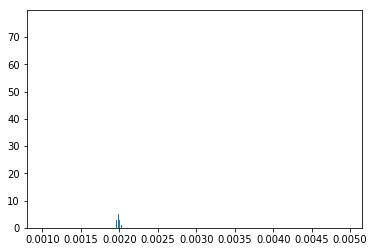

In [219]:
plt.hist(aux, bins='auto')
plt.show()

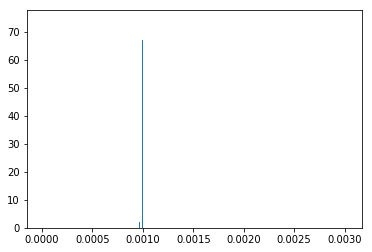

In [220]:
plt.hist(aux2, bins='auto')
plt.show()

In [221]:
index1.statistic

0.32184656076566864

In [222]:
index2.statistic

0.32184656076566864

# Concentration Profile Numpy Comparison

In [83]:
from segregation.conprof import Con_Prof

In [ ]:
"""
Concentration Profile based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import warnings

__all__ = ['Con_Prof']


def _conprof(data, group_pop_var, total_pop_var, m = 1000):
    """
    Calculation of Concentration Profile

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    m             : int
                    a numeric value indicating the number of thresholds to be used. Default value is 1000. 
                    A large value of m creates a smoother-looking graph and a more precise concentration profile value but slows down the calculation speed.

    Attributes
    ----------

    statistic : float
                Concentration Profile Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 

    Notes
    -----
    Based on Hong, Seong-Yun, and Yukio Sadahiro. "Measuring geographic segregation: a graph-based approach." Journal of Geographical Systems 16.2 (2014): 211-231.

    """
    if(type(m) is not int):
        raise TypeError('m must be a string.')
        
    if(m < 2):
        raise ValueError('m must be greater than 1.')
    
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    def calculate_vt(th):
        g_t_i = np.where(g / t >= th, 1, 0)
        v_t = (g_t_i * g).sum() / g.sum()
        return v_t
    
    grid = np.linspace(0, 1, m)
    curve = np.array(list(map(calculate_vt, grid)))
    
    threshold = g.sum() / t.sum()
    R = ((threshold - ((curve[grid < threshold]).sum() / m - (curve[grid >= threshold]).sum()/ m)) / (1 - threshold))
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return R, grid, curve, core_data


class Con_Prof_Numpy:
    """
    Concentration Profile Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    m             : int
                    a numeric value indicating the number of thresholds to be used. 
                    A large value of m creates a smoother-looking graph and a more precise concentration profile value but slows down the calculation speed.

    Attributes
    ----------

    statistic : float
                Concentration Profile Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
        
    Examples
    --------
    In this example, we will calculate the concentration profile (R) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> conprof_index = Con_Prof(df, 'nhblk10', 'pop10')
    >>> conprof_index.statistic
    0.06393365660089256
    
    You can plot the profile curve with the plot method.
    
    >>> conprof_index.plot()
        
    Notes
    -----
    Based on Hong, Seong-Yun, and Yukio Sadahiro. "Measuring geographic segregation: a graph-based approach." Journal of Geographical Systems 16.2 (2014): 211-231.

    """

    def __init__(self, data, group_pop_var, total_pop_var, m = 1000):
        
        aux = _conprof(data, group_pop_var, total_pop_var, m)

        self.statistic = aux[0]
        self.grid      = aux[1]
        self.curve     = aux[2]
        self.core_data = aux[3]
        self._function = _conprof

    def plot(self):
        """
        Plot the Concentration Profile
        """
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib`')
        graph = plt.scatter(self.grid, self.curve, s = 0.1)
        return graph

In [127]:
aux = np.empty(200)
for i in range(200):
    t1 = time.time()
    index1 = Con_Prof(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1

In [128]:
aux2 = np.empty(200)
for i in range(200):
    t1 = time.time()
    index1 = Con_Prof_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [129]:
aux.mean()

0.442239727973938

In [130]:
aux2.mean()

0.011630864143371581

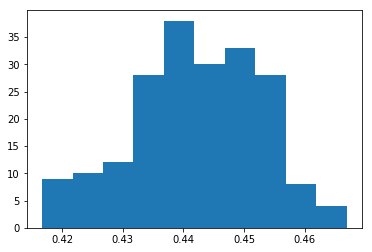

In [131]:
plt.hist(aux, bins='auto')
plt.show()

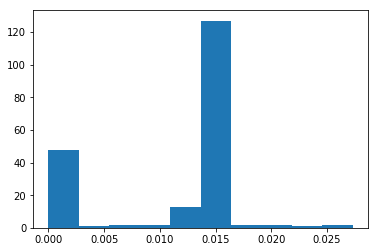

In [132]:
plt.hist(aux2, bins='auto')
plt.show()

In [102]:
index1 = Con_Prof(df, 'HISP_', 'TOT_POP')
index2 = Con_Prof_Numpy(df, 'HISP_', 'TOT_POP')

In [104]:
index1.statistic

0.1376874794741899

In [105]:
index2.statistic

0.1376874794741899

In [117]:
import scipy

In [118]:
from scipy import stats
scipy.stats.ttest_ind(aux, aux2)

Ttest_indResult(statistic=41.34479337376691, pvalue=3.9658737394686736e-146)

# Comparing Gini_Seg with Numpy

In [119]:
from segregation.gini_seg import Gini_Seg

In [133]:
"""
Gini Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Gini_Seg']


def _gini_seg(data, group_pop_var, total_pop_var):
    """
    Calculation of Gini Segregation index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Gini Segregation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = t.sum()
    P = g.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero   
    pi = np.where(t == 0, 0, g / t)
    
    num = (np.matmul(t[np.newaxis].T, t[np.newaxis]) * abs(pi[np.newaxis].T - pi[np.newaxis])).sum()
    den = (2 * T**2 * P * (1-P))
    G = num / den
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return G, core_data


class Gini_Seg_Numpy:
    """
    Classic Gini Segregation Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Gini Segregation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Examples
    --------
    In this example, we will calculate the Gini Segregation Index (G) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> gini_seg_index = Gini_Seg(df, 'nhblk10', 'pop10')
    >>> gini_seg_index.statistic
    0.44620350030600087
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _gini_seg(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _gini_seg


In [145]:
aux = np.empty(2000)
for i in range(2000):
    t1 = time.time()
    index1 = Gini_Seg(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1

In [146]:
aux2 = np.empty(2000)
for i in range(2000):
    t1 = time.time()
    index1 = Gini_Seg_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [147]:
index1 = Gini_Seg(df, 'HISP_', 'TOT_POP')
index2 = Gini_Seg_Numpy(df, 'HISP_', 'TOT_POP')

In [148]:
index1.statistic

0.43506510676886234

In [149]:
index2.statistic

0.43506510676886234

In [150]:
aux.mean()

0.004501140832901001

In [151]:
aux2.mean()

0.0030850419998168944

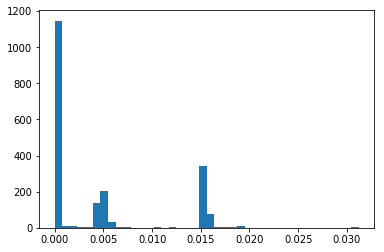

In [152]:
plt.hist(aux, bins='auto')
plt.show()

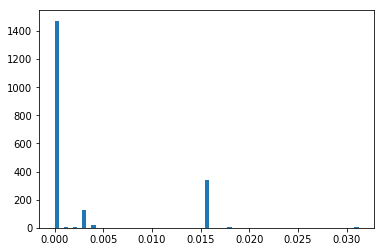

In [153]:
plt.hist(aux2, bins='auto')
plt.show()

In [154]:
scipy.stats.ttest_ind(aux, aux2)

Ttest_indResult(statistic=7.172646158683575, pvalue=8.723146427009791e-13)

# Comparing Atkinson

In [377]:
from segregation.atkinson import Atkinson

In [378]:
"""
Atkinson Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Atkinson']


def _atkinson(data, group_pop_var, total_pop_var, b = 0.5):
    """
    Calculation of Entropy index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkinson Index
    
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if (not isinstance(b, float)):
        raise ValueError('The parameter b must be a float.')
        
    if ((b < 0) or (b > 1)):
        raise ValueError('The parameter b must be between 0 and 1.')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = t.sum()
    P = g.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, g / t)
    
    A = 1 - (P / (1-P)) * abs((((1 - pi) ** (1-b) * pi ** b * t) / (P * T)).sum()) ** (1 / (1 - b))
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return A, core_data


class Atkinson_Numpy:
    """
    Classic Atkinson Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    b             : float
                    The shape parameter, between 0 and 1, that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

    Attributes
    ----------

    statistic : float
                Atkison Index
    
    core_data : a pandas DataFrame
            A pandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the Atkinson Index (A) with the shape parameter (b) equals to 0.5 for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> atkinson_index = Atkinson(df, 'nhblk10', 'pop10', b = 0.5)
    >>> atkinson_index.statistic
    0.16722406110274002
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var, b = 0.5):
        
        aux = _atkinson(data, group_pop_var, total_pop_var, b)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _atkinson



In [388]:
m = 2000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Atkinson(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1

In [389]:
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Atkinson_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [390]:
index1 = Atkinson(df, 'HISP_', 'TOT_POP')
index2 = Atkinson_Numpy(df, 'HISP_', 'TOT_POP')

In [391]:
index1.statistic

0.15079259382667654

In [392]:
index2.statistic

0.15079259382667654

In [393]:
aux.mean()

0.00258002233505249

In [394]:
aux2.mean()

0.0007901396751403808

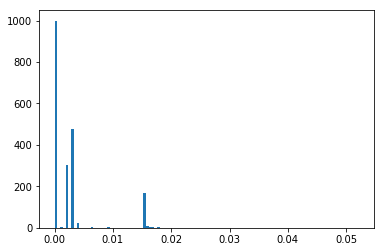

In [395]:
plt.hist(aux, bins='auto')
plt.show()

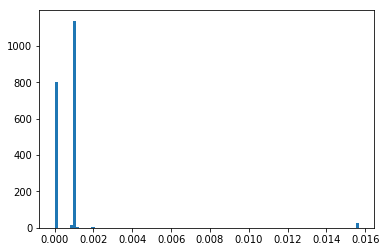

In [396]:
plt.hist(aux2, bins='auto')
plt.show()

# Entropy

In [397]:
from segregation.entropy import Entropy

In [447]:
"""
Entropy Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Entropy']


def _entropy(data, group_pop_var, total_pop_var):
    """
    Calculation of Entropy index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Entropy Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = t.sum()
    P = g.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, g / t)
    
    E = P * np.log(1 / P) + (1 - P) * np.log(1 / (1 - P))
    Ei = pi * np.log(1 / pi) + (1 - pi) * np.log(1 / (1 - pi))
    H = np.nansum(t * (E - Ei) / (E * T))
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return H, core_data


class Entropy_Numpy:
    """
    Classic Entropy Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Entropy Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
        
    Examples
    --------
    In this example, we will calculate the Entropy (H) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> entropy_index = Entropy(df, 'nhblk10', 'pop10')
    >>> entropy_index.statistic
    0.08636489348167173
       
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _entropy(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _entropy



In [451]:
m = 2000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Entropy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Entropy_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply


In [448]:
index1 = Entropy(df, 'HISP_', 'TOT_POP')
index2 = Entropy_Numpy(df, 'HISP_', 'TOT_POP')

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply


In [452]:
index1.statistic

0.09459760633014454

In [453]:
index2.statistic

0.09459760633014454

In [455]:
aux.mean()

0.002880122184753418

In [456]:
aux2.mean()

0.0008177999258041382

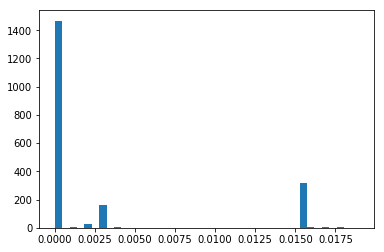

In [457]:
plt.hist(aux, bins='auto')
plt.show()

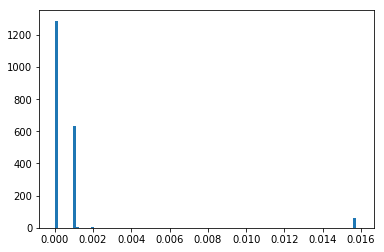

In [458]:
plt.hist(aux2, bins='auto')
plt.show()

# Correlation Ratio

In [459]:
from segregation.correlationr import Correlation_R

In [476]:
"""
Correlation Ratio Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Correlation_R']


def _correlationr(data, group_pop_var, total_pop_var):
    """
    Calculation of Correlation Ratio index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Correlation Ratio Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 

    Notes
    -----
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')

    X = g.sum()
    T = t.sum()
    P = X / T
    
    xPx = ((g / X) * (g / t)).sum()

    V = (xPx - P) / (1 - P)
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return V, core_data


class Correlation_R_Numpy:
    """
    Classic Correlation Ratio Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Correlation Ratio Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
        
    Examples
    --------
    In this example, we will calculate the Correlation Ratio Index (V) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> correlationr_index = Correlation_R(df, 'nhblk10', 'pop10')
    >>> correlationr_index.statistic
    0.048716810856363923
    
    Notes
    -----
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _correlationr(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _correlationr



In [467]:
m = 2000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Correlation_R(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Correlation_R_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [468]:
index1 = Correlation_R(df, 'HISP_', 'TOT_POP')
index2 = Correlation_R_Numpy(df, 'HISP_', 'TOT_POP')

In [469]:
index1.statistic

0.09164042012926693

In [470]:
index2.statistic

0.09164042012926693

In [471]:
aux.mean()

0.0021397008895874025

In [472]:
aux2.mean()

0.0007743566036224366

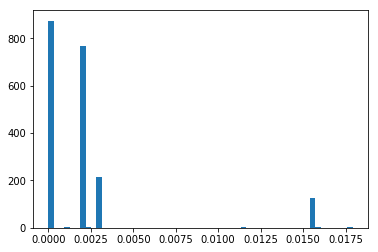

In [473]:
plt.hist(aux, bins='auto')
plt.show()

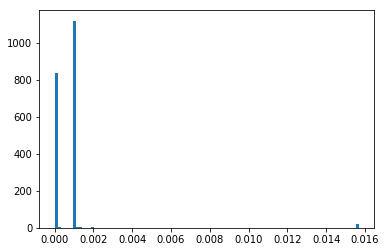

In [474]:
plt.hist(aux2, bins='auto')
plt.show()

# Exposure

In [475]:
from segregation.exposure import Exposure

In [477]:
"""
Exposure Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Exposure']


def _exposure(data, group_pop_var, total_pop_var):
    """
    Calculation of Exposure index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Exposure Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 

    Notes
    -----
    The group of interest is labelled as group X, whilst Y is the complementary group. Groups X and Y are mutually excludent.
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    yi = t - x
    
    X = x.sum()
    xPy = ((x / X) * (yi / t)).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return xPy, core_data


class Exposure_Numpy:
    """
    Classic Exposure Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Exposure Index

    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Examples
    --------
    In this example, we will calculate the Exposure Index (xPy) for the Riverside County using the census tract data of 2010.
    The group of interest (X) is non-hispanic black people which is the variable nhblk10 in the dataset and the Y group is the other part of the population.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> exposure_index = Exposure(df, 'nhblk10', 'pop10')
    >>> exposure_index.statistic
    0.886785172226587
    
    The interpretation of this number is that if you randomly pick a X member of a specific area, there is 88.68% of probability that this member shares a unit with a Y member.
    
    Notes
    -----
    The group of interest is labelled as group X, whilst Y is the complementary group. Groups X and Y are mutually excludent.
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _exposure(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _exposure



In [478]:
index1 = Exposure(df, 'HISP_', 'TOT_POP')
index2 = Exposure_Numpy(df, 'HISP_', 'TOT_POP')

In [479]:
index1.statistic

0.7680384513540848

In [480]:
index2.statistic

0.7680384513540848

In [481]:
m = 100

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Exposure(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Exposure_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [482]:
aux.mean()

0.0024338173866271973

In [483]:
aux2.mean()

0.0007480120658874511

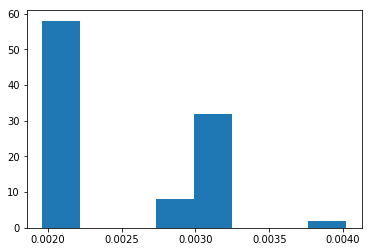

In [484]:
plt.hist(aux, bins='auto')
plt.show()

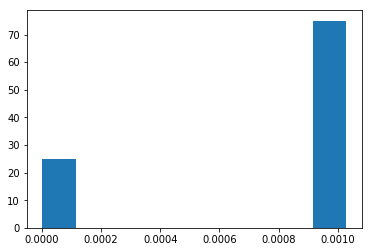

In [485]:
plt.hist(aux2, bins='auto')
plt.show()

# Isolation

In [486]:
from segregation.isolation import Isolation

In [487]:
"""
Isolation Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Isolation']


def _isolation(data, group_pop_var, total_pop_var):
    """
    Calculation of Isolation index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Isolation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    The group of interest is labelled as group X.
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    X = x.sum()
    xPx = ((x / X) * (x / t)).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return xPx, core_data


class Isolation_Numpy:
    """
    Classic Isolation Index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest (X)
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Isolation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.   
                
    Examples
    --------
    In this example, we will calculate the Isolation Index (xPx) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> isolation_index = Isolation(df, 'nhblk10', 'pop10')
    >>> isolation_index.statistic
    0.11321482777341298
    
    The interpretation of this number is that if you randomly pick a X member of a specific area, there is 11.32% of probability that this member shares a unit with another X member.
    
    Notes
    -----
    The group of interest is labelled as group X.
    
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _isolation(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _isolation



In [489]:
m = 200

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Isolation(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Isolation_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Isolation(df, 'HISP_', 'TOT_POP')
index2 = Isolation_Numpy(df, 'HISP_', 'TOT_POP')

In [490]:
index1.statistic

0.2319615486459151

In [491]:
index2.statistic

0.2319615486459151

In [492]:
aux.mean()

0.0020496761798858643

In [493]:
aux2.mean()

0.0007428395748138428

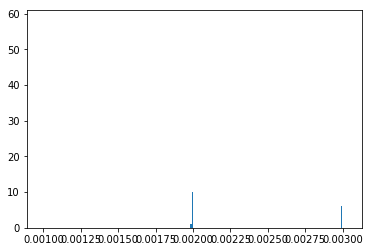

In [494]:
plt.hist(aux, bins='auto')
plt.show()

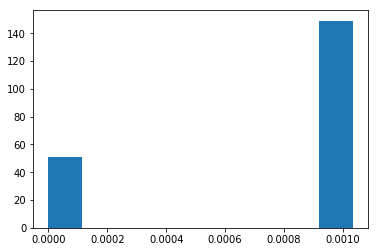

In [495]:
plt.hist(aux2, bins='auto')
plt.show()

# Modified Dissimilarity (needed to use the old \_dissim function to fairly compare the modified one itself)

In [497]:
from segregation.modified_dissimilarity import Modified_Dissim

In [499]:
def _dissim(data, group_pop_var, total_pop_var):
    """
    Calculation of Dissimilarity index
    Parameters
    ----------
    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
    Attributes
    ----------
    statistic : float
                Dissimilarity Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.
    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return D, core_data

In [500]:
"""
Modified Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
#from segregation.dissimilarity import _dissim

__all__ = ['Modified_Dissim']


def _modified_dissim(data, group_pop_var, total_pop_var, iterations = 500):
    """
    Calculation of Modified Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic dissimilarity under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Dissimilarity Index (Dissimilarity from Carrington and Troske (1997))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """
    if(type(iterations) is not int):
        raise TypeError('iterations must be an integer')
        
    if(iterations < 2):
        raise TypeError('iterations must be greater than 1.')
   
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    p_null = x.sum() / t.sum()
    
    
    
    Ds = np.empty(iterations)
    
    for i in np.array(range(iterations)):

        freq_sim = np.random.binomial(n = np.array([t.tolist()]), 
                                      p = np.array([[p_null] * data.shape[0]]), 
                                      size = (1, data.shape[0])).tolist()[0]
        data = data.assign(group_pop_var = freq_sim)
        aux = _dissim(data, 'group_pop_var', 'total_pop_var')[0]
        Ds[i] = aux
        
    D_star = Ds.mean()
    
    if (D >= D_star):
        Dct = (D - D_star)/(1 - D_star)
    else:
        Dct = (D - D_star)/D_star
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return Dct, core_data


class Modified_Dissim_Numpy:
    """
    Calculation of Modified Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic dissimilarity under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Dissimilarity Index (Dissimilarity from Carrington and Troske (1997))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.    
                
    Examples
    --------
    In this example, we will calculate the Modified Dissimilarity Index (Dct) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> np.random.seed(1234)
    >>> modified_dissim_index = Modified_Dissim(df, 'nhblk10', 'pop10')
    >>> modified_dissim_index.statistic
    0.30009504639081996
     
    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """

    def __init__(self, data, group_pop_var, total_pop_var, iterations = 500):
        
        aux = _modified_dissim(data, group_pop_var, total_pop_var, iterations)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _modified_dissim
        

In [506]:
m = 20

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Modified_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Modified_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Modified_Dissim(df, 'HISP_', 'TOT_POP')
index2 = Modified_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [507]:
index1.statistic

0.3107301848115828

In [508]:
index2.statistic

0.3107678495699561

In [509]:
aux.mean()

1.2431516647338867

In [510]:
aux2.mean()

1.1837249398231506

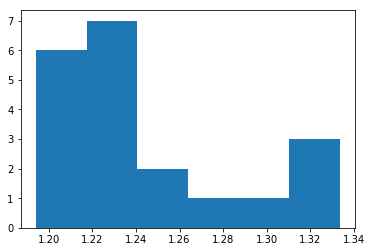

In [511]:
plt.hist(aux, bins='auto')
plt.show()

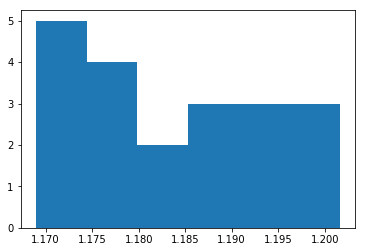

In [512]:
plt.hist(aux2, bins='auto')
plt.show()

# Modified Gini (using old base function a swell)

In [514]:
from segregation.modified_gini_seg import Modified_Gini_Seg

In [515]:
def _gini_seg(data, group_pop_var, total_pop_var):
    """
    Calculation of Gini Segregation index
    Parameters
    ----------
    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
    Attributes
    ----------
    statistic : float
                Gini Segregation Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.
    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    data = data.assign(ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    
    num = (np.matmul(np.array(data.ti)[np.newaxis].T, np.array(data.ti)[np.newaxis]) * abs(np.array(data.pi)[np.newaxis].T - np.array(data.pi)[np.newaxis])).sum()
    den = (2 * T**2 * P * (1-P))
    G = num / den
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return G, core_data

In [516]:
"""
Modified Gini based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from segregation.gini_seg import _gini_seg

__all__ = ['Modified_Gini_Seg']


def _modified_gini_seg(data, group_pop_var, total_pop_var, iterations = 500):
    """
    Calculation of Modified Gini Segregation index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic gini segregation under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Gini Segregation Index (Gini from Carrington and Troske (1997))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
                
    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """
    if(type(iterations) is not int):
        raise TypeError('iterations must be an integer')
        
    if(iterations < 2):
        raise TypeError('iterations must be greater than 1.')
   
    G = _gini_seg(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    p_null = x.sum() / t.sum()
    
    Gs = np.empty(iterations)
    
    for i in np.array(range(iterations)):

        freq_sim = np.random.binomial(n = np.array([t.tolist()]), 
                                      p = np.array([[p_null] * data.shape[0]]), 
                                      size = (1, data.shape[0])).tolist()[0]
        data = data.assign(group_pop_var = freq_sim)
        aux = _gini_seg(data, 'group_pop_var', 'total_pop_var')[0]
        Gs[i] = aux
        
    G_star = Gs.mean()
    
    if (G >= G_star):
        Gct = (G - G_star)/(1 - G_star)
    else:
        Gct = (G - G_star)/G_star

    core_data = data[['group_pop_var', 'total_pop_var']]

    return Gct, core_data


class Modified_Gini_Seg_Numpy:
    """
    Calculation of Modified Gini Segregation index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    iterations    : int
                    The number of iterations the evaluate average classic gini segregation under eveness. Default value is 500.

    Attributes
    ----------

    statistic : float
                Modified Gini Segregation Index (Gini from Carrington and Troske (1997))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.     
                
    Examples
    --------
    In this example, we will calculate the Modified Gini Segregation Index (Gct) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> np.random.seed(1234)
    >>> modified_gini_seg_index = Modified_Gini_Seg(df, 'nhblk10', 'pop10')
    >>> modified_gini_seg_index.statistic
    0.4280279611418648
     
    Notes
    -----
    Based on Carrington, William J., and Kenneth R. Troske. "On measuring segregation in samples with small units." Journal of Business & Economic Statistics 15.4 (1997): 402-409.

    """

    def __init__(self, data, group_pop_var, total_pop_var, iterations = 500):
        
        aux = _modified_gini_seg(data, group_pop_var, total_pop_var, iterations)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _modified_gini_seg
        

In [529]:
m = 250

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Modified_Gini_Seg(df, 'HISP_', 'TOT_POP', iterations = 10)
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Modified_Gini_Seg_Numpy(df, 'HISP_', 'TOT_POP', iterations = 10)
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Modified_Gini_Seg(df, 'HISP_', 'TOT_POP', iterations = 10)
index2 = Modified_Gini_Seg_Numpy(df, 'HISP_', 'TOT_POP', iterations = 10)

In [530]:
index1.statistic

0.4216378441932044

In [531]:
index2.statistic

0.42192193476893425

In [532]:
aux.mean()

0.053652145385742187

In [533]:
aux2.mean()

0.05257040214538574

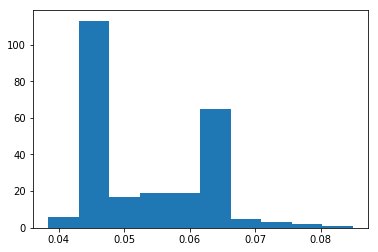

In [534]:
plt.hist(aux, bins='auto')
plt.show()

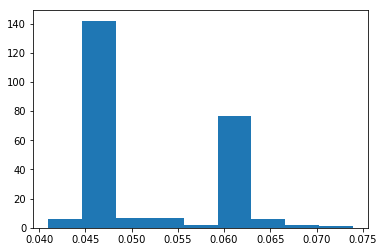

In [535]:
plt.hist(aux2, bins='auto')
plt.show()

# Bias Corrected Dissimilarity

In [536]:
from segregation.bias_corrected_dissimilarity import Bias_Corrected_Dissim

In [538]:
"""
Bias-Corrected Dissimilarity Segregation Index
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from segregation.dissimilarity import _dissim

__all__ = ['Bias_Corrected_Dissim']


def _bias_corrected_dissim(data, group_pop_var, total_pop_var, B = 500):
    """
    Calculation of Bias Corrected Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    B             : int
                    The number of iterations to calculate Dissimilarity simulating randomness with multinomial distributions. Default value is 500.

    Attributes
    ----------

    statistic : float
                Dissimilarity with Bias-Correction (bias correction from Allen, Rebecca et al. (2015))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 

    Notes
    -----
    Based on Allen, Rebecca, et al. "More reliable inference for the dissimilarity index of segregation." The econometrics journal 18.1 (2015): 40-66.

    """
    if(type(B) is not int):
        raise TypeError('B must be an integer')
        
    if(B < 2):
        raise TypeError('B must be greater than 1.')
   
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    other_group_pop = t - x
    
    # Group 0: minority group
    p0_i = x / x.sum()
    n0   = x.sum()
    sim0 = np.random.multinomial(n0, p0_i, size = B)
    
    # Group 1: complement group
    p1_i = other_group_pop / other_group_pop.sum()
    n1   = other_group_pop.sum()
    sim1 = np.random.multinomial(n1, p1_i, size = B)
    
    
    Dbcs = np.empty(B)
    for i in np.array(range(B)):
        data_aux = {'simul_group': sim0[i].tolist(), 'simul_tot': (sim0[i] + sim1[i]).tolist()}
        df_aux = pd.DataFrame.from_dict(data_aux)
        Dbcs[i] = _dissim(df_aux, 'simul_group', 'simul_tot')[0]
        
    Db = Dbcs.mean()
    
    Dbc = 2 * D - Db
    Dbc # It expected to be lower than D, because D is upwarded biased
    
    core_data = data[['group_pop_var', 'total_pop_var']]
        
    return Dbc, core_data


class Bias_Corrected_Dissim_Numpy:
    """
    Calculation of Bias Corrected Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    B             : int
                    The number of iterations to calculate Dissimilarity simulating randomness with multinomial distributions. Default value is 500.

    Attributes
    ----------

    statistic : float
                Dissimilarity with Bias-Correction (bias correction from Allen, Rebecca et al. (2015))
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate. 
        
    Examples
    --------
    In this example, we will calculate the Dissimilarity with Bias Correction (Dbc) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
    
    The value is estimated below.
    
    >>> np.random.seed(1234)
    >>> bias_corrected_dissim_index = Bias_Corrected_Dissim(df, 'nhblk10', 'pop10')
    >>> bias_corrected_dissim_index.statistic
    0.31484636081876954
     
    Notes
    -----
    Based on Allen, Rebecca, et al. "More reliable inference for the dissimilarity index of segregation." The econometrics journal 18.1 (2015): 40-66.

    """

    def __init__(self, data, group_pop_var, total_pop_var, B = 500):
        
        aux = _bias_corrected_dissim(data, group_pop_var, total_pop_var, B)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _bias_corrected_dissim
        
        

In [546]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Bias_Corrected_Dissim(df, 'HISP_', 'TOT_POP', B = 10)
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Bias_Corrected_Dissim_Numpy(df, 'HISP_', 'TOT_POP', B = 10)
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Bias_Corrected_Dissim(df, 'HISP_', 'TOT_POP', B = 10)
index2 = Bias_Corrected_Dissim_Numpy(df, 'HISP_', 'TOT_POP', B = 10)

In [547]:
index1.statistic

0.3212609677657991

In [548]:
index2.statistic

0.32186229933092286

In [549]:
aux.mean()

0.027360074520111084

In [550]:
aux2.mean()

0.026073184967041016

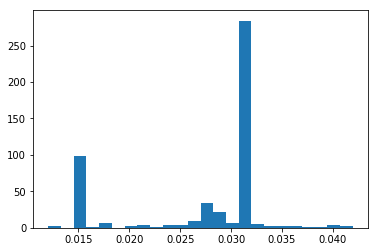

In [551]:
plt.hist(aux, bins='auto')
plt.show()

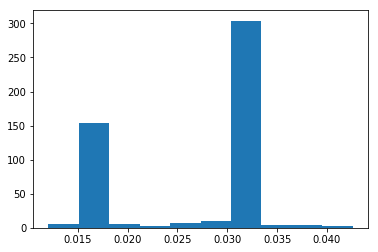

In [552]:
plt.hist(aux2, bins='auto')
plt.show()

# Absolute Concentration

In [557]:
from segregation.absolute_concentration import Absolute_Concentration

In [615]:
"""
Absolute Concentration based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Absolute_Concentration']


def _absolute_concentration(data, group_pop_var, total_pop_var):
    """
    Calculation of Absolute Concentration index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Absolute Concentration Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    area = np.array(data.area)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    X = x.sum()
    T = t.sum()
    
    des_ind = (-area).argsort()
    asc_ind = area.argsort()
    
    n1 = np.where(((np.cumsum(t[asc_ind]) / T) < X/T) == False)[0][0]
    n2 = np.where(((np.cumsum(t[des_ind]) / T) < X/T) == False)[0][0]
    
    n = data.shape[0]
    T1 =  t[asc_ind][0:(n1+1)].sum()
    T2 =  t[asc_ind][n2:n].sum()
    
    ACO = 1- ((((x[asc_ind] * area[asc_ind] / X).sum()) - ((t[asc_ind] * area[asc_ind] / T1)[0:(n1 + 1)].sum())) / \
          (((t[asc_ind] * area[asc_ind] / T2)[n2:n].sum()) - ((t[asc_ind] * area[asc_ind]/T1)[0:(n1 + 1)].sum())))

    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]

    return ACO, core_data


class Absolute_Concentration_Numpy:
    """
    Calculation of Absolute Concentration index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Absolute Concentration Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Examples
    --------
    In this example, we will calculate the absolute concentration index (ACO) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> absolute_concentration_index = Absolute_Concentration(gdf, 'nhblk10', 'pop10')
    >>> absolute_concentration_index.statistic
    0.5430616390401855
            
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _absolute_concentration(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _absolute_concentration

In [616]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Absolute_Concentration(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Absolute_Concentration_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Absolute_Concentration(df, 'HISP_', 'TOT_POP')
index2 = Absolute_Concentration_Numpy(df, 'HISP_', 'TOT_POP')

In [617]:
index1.statistic

0.21496583971774408

In [618]:
index2.statistic

0.21496583971774408

In [619]:
aux.mean()

0.011712728023529052

In [620]:
aux2.mean()

0.002318093776702881

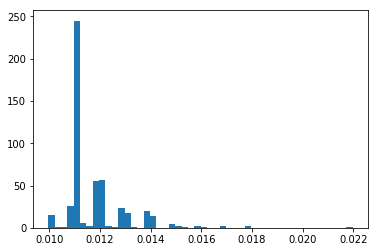

In [621]:
plt.hist(aux, bins='auto')
plt.show()

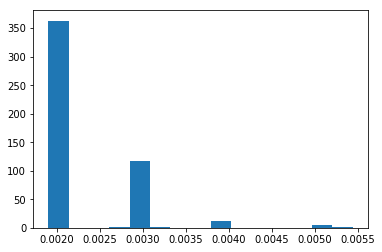

In [622]:
plt.hist(aux2, bins='auto')
plt.show()

# Relative Concentration

In [623]:
from segregation.relative_concentration import Relative_Concentration

In [624]:
"""
Relative Concentration based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Relative_Concentration']


def _relative_concentration(data, group_pop_var, total_pop_var):
    """
    Calculation of Relative Concentration index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Relative Concentration Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    area = np.array(data.area)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    y = t - x
    
    X = x.sum()
    Y = y.sum()
    T = t.sum()
    
    # Create the indexes according to the area ordering
    des_ind = (-area).argsort()
    asc_ind = area.argsort()
    
    n1 = np.where(((np.cumsum(t[asc_ind]) / T) < X/T) == False)[0][0]
    n2 = np.where(((np.cumsum(t[des_ind]) / T) < X/T) == False)[0][0]
    
    n  = data.shape[0]
    T1 = t[asc_ind][0:(n1+1)].sum()
    T2 = t[asc_ind][n2:n].sum()
    
    RCO = ((((x[asc_ind] * area[asc_ind] / X).sum()) / ((y[asc_ind] * area[asc_ind] / Y).sum())) - 1) / \
          ((((t[asc_ind] * area[asc_ind])[0:(n1+1)].sum() / T1) / ((t[asc_ind] * area[asc_ind])[n2:n].sum() / T2)) - 1)
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return RCO, core_data


class Relative_Concentration_Numpy:
    """
    Calculation of Relative Concentration index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Relative Concentration Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
       
    Examples
    --------
    In this example, we will calculate the relative concentration index (RCO) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> relative_concentration_index = Relative_Concentration(gdf, 'nhblk10', 'pop10')
    >>> relative_concentration_index.statistic
    0.5364305924831142
            
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _relative_concentration(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _relative_concentration

In [630]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Concentration(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Concentration_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Relative_Concentration(df, 'HISP_', 'TOT_POP')
index2 = Relative_Concentration_Numpy(df, 'HISP_', 'TOT_POP')

In [631]:
index1.statistic

0.13102848628073688

In [632]:
index2.statistic

0.13102848628073688

In [633]:
aux.mean()

0.011829872131347657

In [634]:
aux2.mean()

0.0023219566345214844

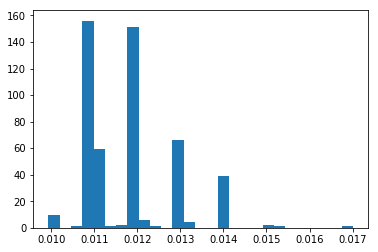

In [635]:
plt.hist(aux, bins='auto')
plt.show()

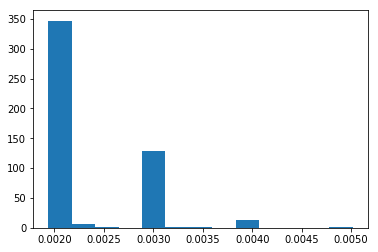

In [636]:
plt.hist(aux2, bins='auto')
plt.show()

# Delta

In [637]:
from segregation.delta import Delta

In [638]:
"""
Delta based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd

__all__ = ['Delta']


def _delta(data, group_pop_var, total_pop_var):
    """
    Calculation of Delta index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Delta Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    area = np.array(data.area)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    X = x.sum()
    A = area.sum()
    
    DEL = 1/2 * abs(x / X - area / A).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return DEL, core_data


class Delta_Numpy:
    """
    Calculation of Delta index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Delta Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
        
    Examples
    --------
    In this example, we will calculate the delta index (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> delta_index = Delta(gdf, 'nhblk10', 'pop10')
    >>> delta_index.statistic
    0.8367330649317353
            
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _delta(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _delta

In [645]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Delta(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Delta_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Delta(df, 'HISP_', 'TOT_POP')
index2 = Delta_Numpy(df, 'HISP_', 'TOT_POP')

In [646]:
index1.statistic

0.8044969214141899

In [647]:
index2.statistic

0.8044969214141899

In [648]:
aux.mean()

0.004279277801513672

In [649]:
aux2.mean()

0.002245023727416992

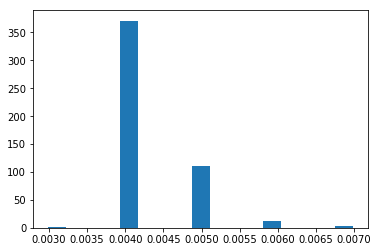

In [650]:
plt.hist(aux, bins='auto')
plt.show()

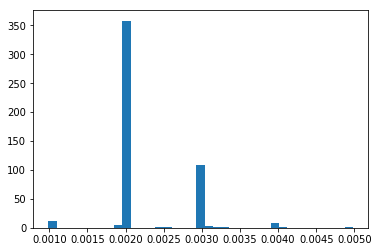

In [651]:
plt.hist(aux2, bins='auto')
plt.show()

# Absolute Centralization

In [652]:
from segregation.absolute_centralization import Absolute_Centralization

In [672]:
"""
Absolute Centralization based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift

__all__ = ['Absolute_Centralization']


def _absolute_centralization(data, group_pop_var, total_pop_var):
    """
    Calculation of Absolute Centralization index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Absolute Centralization Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
        
    y = t - x
    
    area = np.array(data.area)
    
    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    center_lon = c_lons.mean()
    center_lat = c_lats.mean()
    
    X = x.sum()
    Y = y.sum()
    A = area.sum()

    center_dist = np.sqrt((c_lons - center_lon) ** 2 + (c_lats - center_lat) ** 2)
    
    asc_ind = center_dist.argsort() 
    
    Xi = np.cumsum(x[asc_ind]) / X
    Yi = np.cumsum(y[asc_ind]) / Y
    Ai = np.cumsum(area[asc_ind]) / A
    
    ACE = np.nansum(shift(Xi, 1, cval=np.NaN) * Ai) - \
          np.nansum(Xi * shift(Ai, 1, cval=np.NaN))
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return ACE, core_data


class Absolute_Centralization_Numpy:
    """
    Calculation of Absolute Centralization index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Absolute Centralization Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Examples
    --------
    In this example, we will calculate the absolute centralization index (ACE) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> absolute_centralization_index = Absolute_Centralization(gdf, 'nhblk10', 'pop10')
    >>> absolute_centralization_index.statistic
    0.6416113799795511
            
    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _absolute_centralization(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _absolute_centralization

In [692]:
m = 1000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Absolute_Centralization(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Absolute_Centralization_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Absolute_Centralization(df, 'HISP_', 'TOT_POP')
index2 = Absolute_Centralization_Numpy(df, 'HISP_', 'TOT_POP')

In [693]:
index1.statistic

0.6891422368736286

In [694]:
index2.statistic

0.6891422368736286

In [695]:
aux.mean()

0.026677662134170534

In [696]:
aux2.mean()

0.019124469995498657

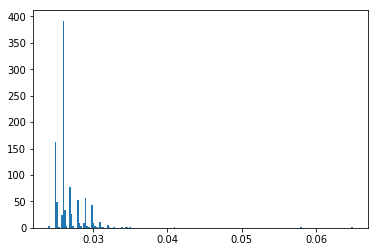

In [697]:
plt.hist(aux, bins='auto')
plt.show()

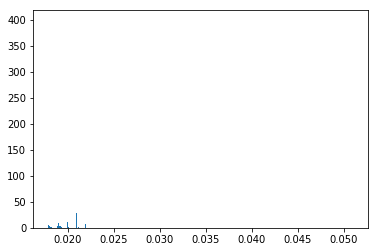

In [698]:
plt.hist(aux2, bins='auto')
plt.show()

# Relative Centralization

In [699]:
from segregation.relative_centralization import Relative_Centralization

In [801]:
"""
Relative Centralization based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift

__all__ = ['Relative_Centralization']


def _relative_centralization(data, group_pop_var, total_pop_var):
    """
    Calculation of Relative Centralization index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Relative Centralization Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})

    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')

    y = t - x
    area = np.array(data.area)
    
    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    center_lon = c_lons.mean()
    center_lat = c_lats.mean()
    
    X = x.sum()
    Y = y.sum()
    A = area.sum()

    center_dist = np.sqrt((c_lons - center_lon) ** 2 + (c_lats - center_lat) ** 2)
    
    asc_ind = center_dist.argsort() 
    
    Xi = np.cumsum(x[asc_ind]) / X
    Yi = np.cumsum(y[asc_ind]) / Y
    Ai = np.cumsum(area[asc_ind]) / A
    
    RCE = np.nansum(shift(Xi, 1, cval=np.NaN) * Yi) - \
          np.nansum(Xi * shift(Yi, 1, cval=np.NaN))

    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]

    return RCE, core_data


class Relative_Centralization_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _relative_centralization(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _relative_centralization

In [807]:
m = 1000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Centralization(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Centralization_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Relative_Centralization(df, 'HISP_', 'TOT_POP')
index2 = Relative_Centralization_Numpy(df, 'HISP_', 'TOT_POP')

In [808]:
index1.statistic

-0.11194177550430595

In [809]:
index2.statistic

-0.11194177550430595

In [810]:
aux.mean()

0.026999698638916016

In [811]:
aux2.mean()

0.020220618724823

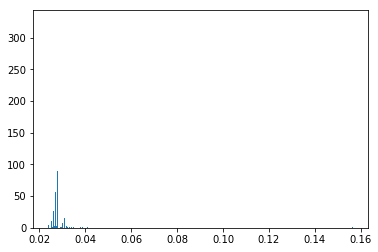

In [812]:
plt.hist(aux, bins='auto')
plt.show()

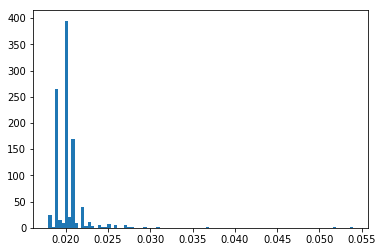

In [813]:
plt.hist(aux2, bins='auto')
plt.show()

In [814]:
from sklearn.metrics.pairwise import euclidean_distances

In [819]:
euclidean_distances(np.array([2,3,43], [2,3,43]))

TypeError: data type not understood

In [820]:
help(euclidean_distances)

Help on function euclidean_distances in module sklearn.metrics.pairwise:

euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None)
    Considering the rows of X (and Y=X) as vectors, compute the
    distance matrix between each pair of vectors.
    
    For efficiency reasons, the euclidean distance between a pair of row
    vector x and y is computed as::
    
        dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    
    This formulation has two advantages over other ways of computing distances.
    First, it is computationally efficient when dealing with sparse data.
    Second, if one argument varies but the other remains unchanged, then
    `dot(x, x)` and/or `dot(y, y)` can be pre-computed.
    
    However, this is not the most precise way of doing this computation, and
    the distance matrix returned by this function may not be exactly
    symmetric as required by, e.g., ``scipy.spatial.distance`` functions.
    
    Read more in the :

In [823]:
# Inspired in: https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
z = np.array([2,3,8,-1])
m, n = np.meshgrid(z, z)
out = abs(m-n)

In [824]:
out

array([[0, 1, 6, 3],
       [1, 0, 5, 4],
       [6, 5, 0, 9],
       [3, 4, 9, 0]])

In [825]:
data.head()

,geometry,group_pop_var,total_pop_var,xi,yi,ti,area,c_lons,c_lats,center_lon,center_lat,center_dist
0,"POLYGON ((-120.217504 39.162085, -120.220064 3...",336,5501,336,5165,5501,0.081153,-120.474460,39.248381,-121.301818,38.633839,1.030622
1,"POLYGON ((-120.064072 39.236687, -120.064115 3...",391,2072,391,1681,2072,0.002289,-120.039825,39.263190,-121.301818,38.633839,1.410216
2,"POLYGON ((-120.00526 39.279982, -120.005266 39...",1918,3633,1918,1715,3633,0.000794,-120.013842,39.251425,-121.301818,38.633839,1.428388
3,"POLYGON ((-120.095366 39.197183, -120.095761 3...",60,1683,60,1623,1683,0.002881,-120.103726,39.232051,-121.301818,38.633839,1.339135
4,"POLYGON ((-121.038014 38.931727, -121.037162 3...",251,5794,251,5543,5794,0.152799,-120.575665,39.086643,-121.301818,38.633839,0.855763


In [826]:
euclidean_distances(data[['xi']])

array([[   0.,   55., 1582., ..., 1671.,  232.,   47.],
       [  55.,    0., 1527., ..., 1616.,  177.,    8.],
       [1582., 1527.,    0., ...,   89., 1350., 1535.],
       ...,
       [1671., 1616.,   89., ...,    0., 1439., 1624.],
       [ 232.,  177., 1350., ..., 1439.,    0.,  185.],
       [  47.,    8., 1535., ..., 1624.,  185.,    0.]])

# Spatial Dissimilarity

In [827]:
from segregation.spatial_dissimilarity import Spatial_Dissim

In [845]:
"""
Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import libpysal
from segregation.dissimilarity import _dissim
from libpysal.weights import Queen
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Spatial_Dissim']


def _spatial_dissim(data, group_pop_var, total_pop_var, w = None, standardize = False):
    """
    Calculation of Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    w             : W
                    A PySAL weights object. If not provided, Queen contiguity matrix is used.
                    
    standardize   : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default with row standardization.
        

    Attributes
    ----------

    statistic : float
                Spatial Dissimilarity Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Notes
    -----
    Based on Morrill, R. L. (1991) "On the Measure of Geographic Segregation". Geography Research Forum.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if (type(standardize) is not bool):
        raise TypeError('std is not a boolean object')
        
    if w is None:    
        w_object = Queen.from_dataframe(data)
    else:
        w_object = w
    
    if (not issubclass(type(w_object), libpysal.weights.W)):
        raise TypeError('w is not a PySAL weights object')
    
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, x / t)
    
    if not standardize:
        cij = w_object.full()[0]
    else:
        cij = w_object.full()[0]
        cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

    # Inspired in (second solution): https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
    # Distance Matrix
    abs_dist = abs(pi[..., np.newaxis] - pi)
        
    # manhattan_distances used to compute absolute distances
    num = np.multiply(abs_dist, cij).sum()
    den = cij.sum()
    SD = D - num / den
    SD
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return SD, core_data


class Spatial_Dissim_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, w = None, standardize = False):
        
        aux = _spatial_dissim(data, group_pop_var, total_pop_var, w, standardize)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _spatial_dissim

In [853]:
m = 100

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Spatial_Dissim(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [854]:
index1.statistic

0.2611974332919437

In [855]:
index2.statistic

0.2611974332919437

In [856]:
aux.mean()

0.3786319756507874

In [857]:
aux2.mean()

0.3710501766204834

In [860]:
0.3710501766204834/0.3786319756507874

0.9799758089176899

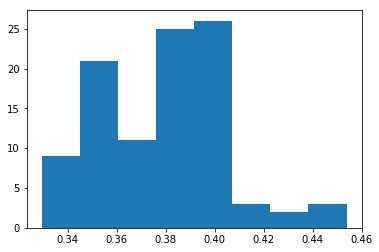

In [858]:
plt.hist(aux, bins='auto')
plt.show()

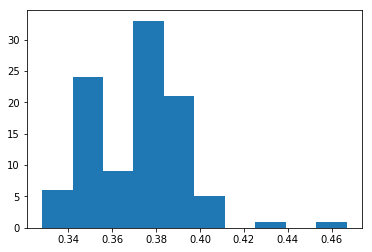

In [859]:
plt.hist(aux2, bins='auto')
plt.show()

# Boundary Spatial Dissimilarity (old code is more efficient!)

In [861]:
from segregation.boundary_spatial_dissimilarity import Boundary_Spatial_Dissim

In [864]:
"""
Boundary Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
#import libpysal
from segregation.util import _return_length_weighted_w
from segregation.dissimilarity import _dissim
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Boundary_Spatial_Dissim']


def _boundary_spatial_dissim(data, group_pop_var, total_pop_var, standardize = False):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if (type(standardize) is not bool):
        raise TypeError('std is not a boolean object')
    
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, x / t)

    if not standardize:
        cij = _return_length_weighted_w(data).full()[0]
    else:
        cij = _return_length_weighted_w(data).full()[0]
        cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

    
    # Inspired in (second solution): https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
    # Distance Matrix
    abs_dist = abs(pi[..., np.newaxis] - pi)
    
    # manhattan_distances used to compute absolute distances
    num = np.multiply(abs_dist, cij).sum()
    den = cij.sum()
    BSD = D - num / den
    BSD
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return BSD, core_data


class Boundary_Spatial_Dissim_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, standardize = False):
        
        aux = _boundary_spatial_dissim(data, group_pop_var, total_pop_var, standardize)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _boundary_spatial_dissim

In [872]:
m = 25

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Boundary_Spatial_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Boundary_Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Boundary_Spatial_Dissim(df, 'HISP_', 'TOT_POP')
index2 = Boundary_Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [873]:
index1.statistic

0.2667626367289605

In [874]:
index2.statistic

0.2667626367289605

In [875]:
aux.mean()

1.934177770614624

In [876]:
aux2.mean()

1.991007318496704

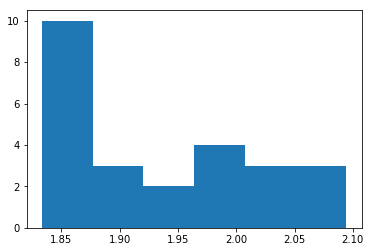

In [877]:
plt.hist(aux, bins='auto')
plt.show()

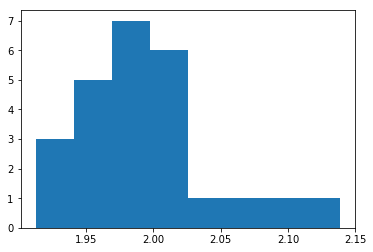

In [878]:
plt.hist(aux2, bins='auto')
plt.show()

# Spatial Proximity Profile (old code is faster!)

In [880]:
from segregation.spatial_prox_profile import Spatial_Prox_Prof

In [896]:
"""
Spatial Proximity Profile based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import warnings
from libpysal.weights import Queen
from numpy import inf
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Spatial_Prox_Prof']


def _spatial_prox_profile(data, group_pop_var, total_pop_var, m = 1000):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if(type(m) is not int):
        raise TypeError('m must be a string.')
        
    if(m < 2):
        raise ValueError('m must be greater than 1.')
    
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')

    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
        
    wij = Queen.from_dataframe(data).full()[0]
    
    # Inspired in (second solution): https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
    # Distance Matrix
    #delta = abs(wij[..., np.newaxis] - wij)
    delta = manhattan_distances(wij)
    
    def calculate_etat(t):
        g_t_i = np.where(x / t >= t, True, False)
        k = g_t_i.sum()
        sub_delta_ij = delta[g_t_i,:][:,g_t_i]
        den = sub_delta_ij.sum()
        eta_t = (k**2 - k) / den
        return eta_t
    
    grid = np.linspace(0, 1, m)
    aux = np.array(list(map(calculate_etat, grid)))
    aux[aux == inf] = 0
    aux[aux == -inf] = 0
    curve = np.nan_to_num(aux, 0)
    
    threshold = x.sum() / t.sum()
    SPP = ((threshold - ((curve[grid < threshold]).sum() / m - (curve[grid >= threshold]).sum()/ m)) / (1 - threshold))
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return SPP, grid, curve, core_data


class Spatial_Prox_Prof_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, m = 1000):
        
        aux = _spatial_prox_profile(data, group_pop_var, total_pop_var, m)

        self.statistic = aux[0]
        self.grid      = aux[1]
        self.curve     = aux[2]
        self.core_data = aux[3]
        self._function = _spatial_prox_profile

    def plot(self):
        """
        Plot the Spatial Proximity Profile
        """
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            warnings.warn('This method relies on importing `matplotlib`')
        graph = plt.scatter(self.grid, self.curve, s = 0.1)
        return graph


In [892]:
wij = Queen.from_dataframe(data).full()[0]

In [907]:
wij.sum()

2522.0

In [895]:
manhattan_distances(wij)

array([[ 0.,  8.,  9., ..., 11., 12.,  9.],
       [ 8.,  0.,  3., ...,  7.,  8.,  5.],
       [ 9.,  3.,  0., ...,  6.,  7.,  4.],
       ...,
       [11.,  7.,  6., ...,  0.,  3.,  4.],
       [12.,  8.,  7., ...,  3.,  0.,  5.],
       [ 9.,  5.,  4., ...,  4.,  5.,  0.]])

In [897]:
%%time
index1 = Spatial_Prox_Prof(df, 'HISP_', 'TOT_POP', m = 20)

Wall time: 412 ms


c:\users\renan\desktop\inequality\segregation\spatial_prox_profile.py:85: RuntimeWarning: invalid value encountered in true_divide
  eta_t = (k**2 - k) / den


In [898]:
%%time
index2 = Spatial_Prox_Prof_Numpy(df, 'HISP_', 'TOT_POP', m = 20)

Wall time: 464 ms


C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal


In [900]:
m = 10

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Prox_Prof(df, 'HISP_', 'TOT_POP', m = 20)
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Prox_Prof_Numpy(df, 'HISP_', 'TOT_POP', m = 20)
    t2 = time.time()
    aux2[i] = t2-t1
    
index1 = Spatial_Prox_Prof(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Prox_Prof_Numpy(df, 'HISP_', 'TOT_POP')

c:\users\renan\desktop\inequality\segregation\spatial_prox_profile.py:85: RuntimeWarning: invalid value encountered in true_divide
  eta_t = (k**2 - k) / den
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal


In [901]:
index1.statistic

0.20876837685147084

In [902]:
index2.statistic

0.24888277168518919

In [903]:
aux.mean()

0.44795353412628175

In [904]:
aux2.mean()

0.4655726909637451

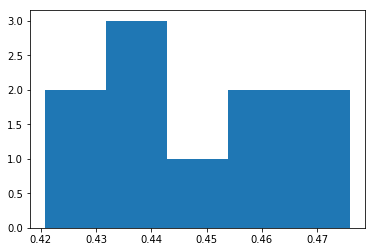

In [905]:
plt.hist(aux, bins='auto')
plt.show()

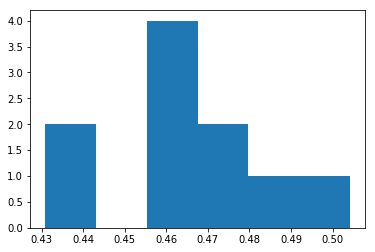

In [906]:
plt.hist(aux2, bins='auto')
plt.show()

# Perimiter Area (old code is faster)

In [908]:
from segregation.perimeter_area_ratio_spatial_dissimilarity import Perimeter_Area_Ratio_Spatial_Dissim

In [912]:
"""
Perimeter/Area Ratio Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
#import libpysal
from segregation.util import _return_length_weighted_w
from segregation.dissimilarity import _dissim
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Perimeter_Area_Ratio_Spatial_Dissim']


def _perimeter_area_ratio_spatial_dissim(data, group_pop_var, total_pop_var, standardize = True):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if (type(standardize) is not bool):
        raise TypeError('std is not a boolean object')
    
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, x / t)

    if not standardize:
        cij = _return_length_weighted_w(data).full()[0]
    else:
        cij = _return_length_weighted_w(data).full()[0]
        cij = cij / cij.sum()
   
    peri = np.array(data.length)
    ai   = np.array(data.area)
    
    aux_sum = np.add(peri / ai, (peri / ai).reshape((len(list(peri / ai)),1)))
    
    max_pa = max(peri / ai)
    
    # Inspired in (second solution): https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
    # Distance Matrix
    abs_dist = abs(pi[..., np.newaxis] - pi)
    
    num = np.multiply(np.multiply(abs_dist, cij), aux_sum).sum()
    den = 4 * max_pa
    
    PARD = D - (num / den)
    PARD
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return PARD, core_data


class Perimeter_Area_Ratio_Spatial_Dissim_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, standardize = True):
        
        aux = _perimeter_area_ratio_spatial_dissim(data, group_pop_var, total_pop_var, standardize)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _perimeter_area_ratio_spatial_dissim

In [924]:
m = 25

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Perimeter_Area_Ratio_Spatial_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Perimeter_Area_Ratio_Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [925]:
aux.mean()

1.9037964344024658

In [926]:
aux2.mean()

1.9543843936920167

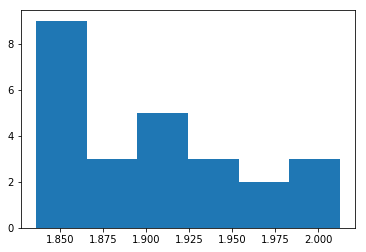

In [927]:
plt.hist(aux, bins='auto')
plt.show()

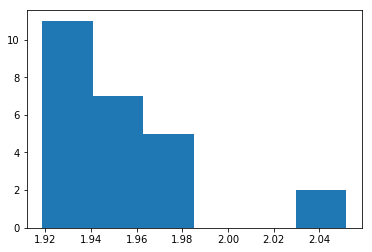

In [928]:
plt.hist(aux2, bins='auto')
plt.show()

# Relative Clustering

In [948]:
from segregation.relative_clustering import Relative_Clustering

In [946]:
"""
Relative Clustering based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

__all__ = ['Relative_Clustering']


def _relative_clustering(data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    if (alpha < 0):
        raise ValueError('alpha must be greater than zero.')
    
    if (beta < 0):
        raise ValueError('beta must be greater than zero.')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    area = np.array(data.area)
    
    y = t - x

    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    X = x.sum()
    Y = y.sum()
    
    dist = euclidean_distances(pd.DataFrame({'c_lons': c_lons, 'c_lats': c_lats}))
    np.fill_diagonal(dist, val = (alpha * area) ** (beta))
    c = np.exp(-dist)
    
    Pxx = ((x * c).T * x).sum() / X**2
    Pyy = ((y * c).T * y).sum() / Y**2
    RCL = Pxx / Pyy - 1
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return RCL, core_data


class Relative_Clustering_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
        
        aux = _relative_clustering(data, group_pop_var, total_pop_var, alpha, beta)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _relative_clustering

In [955]:
m = 1000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Clustering(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Relative_Clustering_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [956]:
index1 = Relative_Clustering(df, 'HISP_', 'TOT_POP')
index2 = Relative_Clustering_Numpy(df, 'HISP_', 'TOT_POP')

In [957]:
index1.statistic

0.009095632468738568

In [958]:
index2.statistic

0.009095632468738568

In [959]:
aux.mean()

0.02711879539489746

In [960]:
aux2.mean()

0.02657820963859558

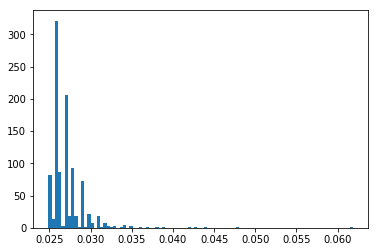

In [961]:
plt.hist(aux, bins='auto')
plt.show()

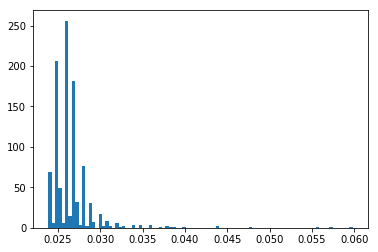

In [962]:
plt.hist(aux2, bins='auto')
plt.show()

# Spatial Exposure

In [964]:
from segregation.spatial_exposure import Spatial_Exposure

In [965]:
"""
Spatial Exposure based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

__all__ = ['Spatial_Exposure']


def _spatial_exposure(data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    if (alpha < 0):
        raise ValueError('alpha must be greater than zero.')
    
    if (beta < 0):
        raise ValueError('beta must be greater than zero.')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})

    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    y = t - x
    
    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    X = x.sum()
    
    dist = euclidean_distances(pd.DataFrame({'c_lons': c_lons, 'c_lats': c_lats}))
    np.fill_diagonal(dist, val = (alpha * data.area) ** (beta))
    c = np.exp(-dist)
    
    Pij  = np.multiply(c, t) / np.sum(np.multiply(c, t), axis = 1)
    SxPy = (x / X * np.nansum(np.multiply(Pij, y / t), axis = 1)).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return SxPy, core_data


class Spatial_Exposure_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
        
        aux = _spatial_exposure(data, group_pop_var, total_pop_var, alpha, beta)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _spatial_exposure

In [966]:
index1 = Spatial_Exposure(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Exposure_Numpy(df, 'HISP_', 'TOT_POP')

In [967]:
index1.statistic

0.8396583368412371

In [968]:
index2.statistic

0.8396583368412371

In [969]:
m = 1000

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Exposure(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Exposure_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [970]:
aux.mean()

0.02769722127914429

In [971]:
aux2.mean()

0.02527258777618408

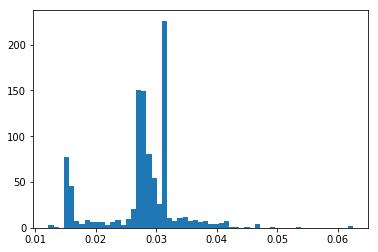

In [972]:
plt.hist(aux, bins='auto')
plt.show()

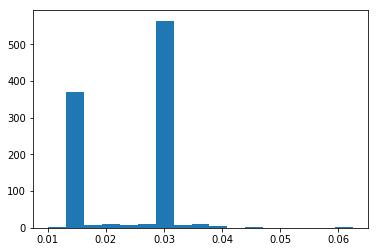

In [973]:
plt.hist(aux2, bins='auto')
plt.show()

# Spatial Proximity

In [980]:
from segregation.spatial_proximity import Spatial_Proximity

In [985]:
"""
Spatial Proximity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

__all__ = ['Spatial_Proximity']


def _spatial_proximity(data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    if (alpha < 0):
        raise ValueError('alpha must be greater than zero.')
    
    if (beta < 0):
        raise ValueError('beta must be greater than zero.')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
   
    T = t.sum()
    
    y = t - x
    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    X = x.sum()
    Y = y.sum()
    
    dist = euclidean_distances(pd.DataFrame({'c_lons': c_lons, 'c_lats': c_lats}))
    np.fill_diagonal(dist, val = (alpha * data.area) ** (beta))
    c = np.exp(-dist)
    
    Pxx = ((x * c).T * x).sum() / X**2
    Pyy = ((y * c).T * y).sum() / Y**2
    Ptt = ((t * c).T * t).sum() / T**2
    SP = (X * Pxx + Y * Pyy) / (T * Ptt)
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]   
    
    return SP, core_data


class Spatial_Proximity_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
        
        aux = _spatial_proximity(data, group_pop_var, total_pop_var, alpha, beta)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _spatial_proximity

In [986]:
index1 = Spatial_Proximity(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Proximity_Numpy(df, 'HISP_', 'TOT_POP')

In [987]:
index1.statistic

1.0026623464135092

In [988]:
index2.statistic

1.0026623464135092

In [992]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Proximity(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Proximity_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [993]:
aux.mean()

0.02883445167541504

In [994]:
aux2.mean()

0.025969193935394288

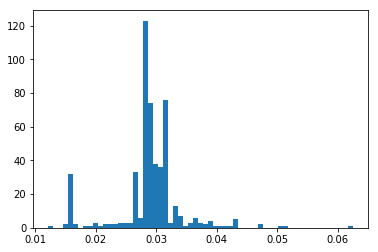

In [995]:
plt.hist(aux, bins='auto')
plt.show()

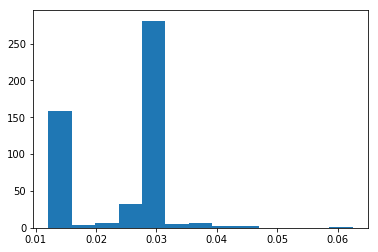

In [996]:
plt.hist(aux2, bins='auto')
plt.show()

# Spatial Isolation

In [997]:
from segregation.spatial_isolation import Spatial_Isolation

In [998]:
"""
Spatial Isolation based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

__all__ = ['Spatial_Isolation']


def _spatial_isolation(data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    if (alpha < 0):
        raise ValueError('alpha must be greater than zero.')
    
    if (beta < 0):
        raise ValueError('beta must be greater than zero.')
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    x = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < x):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    c_lons = np.array(data.centroid.x)
    c_lats = np.array(data.centroid.y)
    
    X = x.sum()
    
    dist = euclidean_distances(pd.DataFrame({'c_lons': c_lons, 'c_lats': c_lats}))
    np.fill_diagonal(dist, val = (alpha * data.area) ** (beta))
    c = np.exp(-dist)
    
    Pij  = np.multiply(c, t) / np.sum(np.multiply(c, t), axis = 1)
    SxPx = (np.array(x / X) * np.nansum(np.multiply(Pij, np.array(x / t)), axis = 1)).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return SxPx, core_data


class Spatial_Isolation_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var, alpha = 0.6, beta = 0.5):
        
        aux = _spatial_isolation(data, group_pop_var, total_pop_var, alpha, beta)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _spatial_isolation

In [999]:
index1 = Spatial_Isolation(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Isolation_Numpy(df, 'HISP_', 'TOT_POP')

In [1000]:
index1.statistic

0.1562162475606278

In [1001]:
index2.statistic

0.1562162475606278

In [1002]:
m = 500

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Isolation(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Spatial_Isolation_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [1003]:
aux.mean()

0.027136649131774902

In [1004]:
aux2.mean()

0.02661361026763916

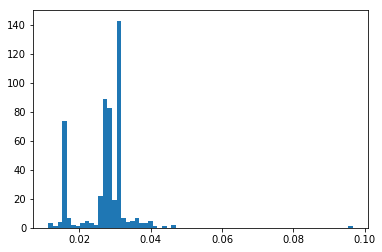

In [1005]:
plt.hist(aux, bins='auto')
plt.show()

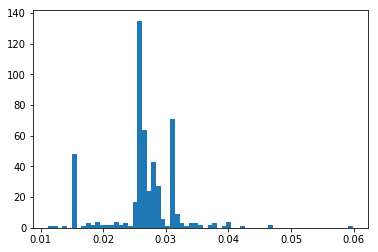

In [1006]:
plt.hist(aux2, bins='auto')
plt.show()

# Comparing Density Corrected Dissimilarity

In [1007]:
from segregation.density_corrected_dissimilarity import Density_Corrected_Dissim

In [1090]:
"""
Density-Corrected Dissimilarity Segregation Index
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

__all__ = ['Density_Corrected_Dissim']


def _density_corrected_dissim(data, group_pop_var, total_pop_var, xtol = 1e-4):
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    g = np.array(data.group_pop_var)
    t = np.array(data.total_pop_var)
    
    if any(t < g):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    other_group_pop = t - g
    
    # Group 0: minority group
    p0_i = g / g.sum()
    n0 = g.sum()
    
    # Group 1: complement group
    p1_i = other_group_pop / other_group_pop.sum()
    n1 = other_group_pop.sum()
    
    sigma_hat_j = np.sqrt(((p1_i * (1 - p1_i)) / n1) + ((p0_i * (1 - p0_i)) / n0))
    theta_hat_j = abs(p1_i - p0_i) / sigma_hat_j
    
    # Constructing function that returns $n(\hat{\theta}_j)$
    def return_optimal_theta(theta_j):
        
        def fold_norm(x):
            y = (-1) * (norm.pdf(x - theta_j) + norm.pdf(x + theta_j))
            return y
        
        initial_guesses = np.array(0)
        #initial_guesses = theta_hat_j.mean()
        res = minimize(fold_norm, 
                       initial_guesses, 
                       method='nelder-mead',
                       options = {'xtol': xtol})
        return res.final_simplex[0][1][0]
        
    optimal_thetas = pd.Series(data = theta_hat_j).apply(return_optimal_theta)
    #optimal_thetas = return_optimal_theta(theta_hat_j)
    #optimal_thetas = np.array(list(map(return_optimal_theta, theta_hat_j)))
    
    
    #Ddc = (sigma_hat_j * optimal_thetas).sum() / 2
    Ddc = np.multiply(sigma_hat_j, optimal_thetas).sum() / 2
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return Ddc, core_data


class Density_Corrected_Dissim_Numpy:

    def __init__(self, data, group_pop_var, total_pop_var):
        
        aux = _density_corrected_dissim(data, group_pop_var, total_pop_var)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _density_corrected_dissim

In [1082]:
s_map = gpd.read_file(libpysal.examples.get_path("sacramentot2.shp"))
df = s_map[['geometry', 'HISP_', 'TOT_POP']]
index = Density_Corrected_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [1083]:
index.statistic

0.295205155464069

In [1086]:
import os
os.chdir('C:\\Users\\renan\\Desktop\\full_count_2010')

In [1089]:
filepath = 'std_2010_fullcount.csv'
census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
df = census_2010.loc[census_2010.county == "Riverside County"][['pop10','nhblk10']]
density_corrected_dissim_index = Density_Corrected_Dissim_Numpy(df, 'nhblk10', 'pop10')
density_corrected_dissim_index.statistic

0.29350643204887517

In [1096]:
index1 = Density_Corrected_Dissim(df, 'HISP_', 'TOT_POP')
index2 = Density_Corrected_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [1097]:
index1.statistic

0.2952051469981647

In [1098]:
index2.statistic

0.29520521387730086

In [1099]:
m = 5

aux = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Density_Corrected_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1
    
aux2 = np.empty(m)
for i in range(m):
    t1 = time.time()
    index1 = Density_Corrected_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [1105]:
3.557942581176758/5.149553298950195

0.6909225664101956

In [1101]:
aux.mean()

5.149553298950195

In [1102]:
aux2.mean()

3.557942581176758

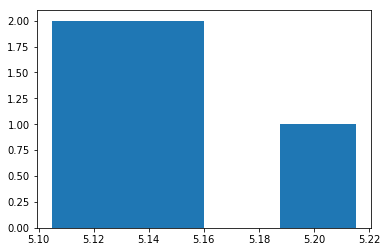

In [1103]:
plt.hist(aux, bins='auto')
plt.show()

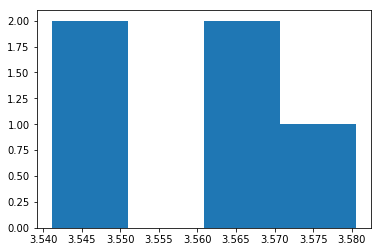

In [1104]:
plt.hist(aux2, bins='auto')
plt.show()

In [273]:
scipy.stats.ttest_ind(aux, aux2)

Ttest_indResult(statistic=-1.4759709187181538, pvalue=0.1415402301591242)

# Spatial Dissimilarity

In [282]:
from segregation.spatial_dissimilarity import Spatial_Dissim

In [346]:
def _dissim(data, group_pop_var, total_pop_var):
    """
    Calculation of Dissimilarity index

    Parameters
    ----------

    data          : a pandas DataFrame
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit

    Attributes
    ----------

    statistic : float
                Dissimilarity Index
                
    core_data : a pandas DataFrame
                A pandas DataFrame that contains the columns used to perform the estimate.

    Notes
    -----
    Based on Massey, Douglas S., and Nancy A. Denton. "The dimensions of residential segregation." Social forces 67.2 (1988): 281-315.

    """
    if((type(group_pop_var) is not str) or (type(total_pop_var) is not str)):
        raise TypeError('group_pop_var and total_pop_var must be strings')
    
    if ((group_pop_var not in data.columns) or (total_pop_var not in data.columns)):    
        raise ValueError('group_pop_var and total_pop_var must be variables of data')
        
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    if any(data.total_pop_var < data.group_pop_var):    
        raise ValueError('Group of interest population must equal or lower than the total population of the units.')
    
    t = np.array(data.total_pop_var)
    g = np.array(data.group_pop_var)
    
    T = t.sum()
    P = g.sum() / T
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, g/t)
    
    D = (((t * abs(pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    core_data = data[['group_pop_var', 'total_pop_var']]
    
    return D, core_data

In [348]:

"""
Spatial Dissimilarity based Segregation Metrics
"""

__author__ = "Renan X. Cortes <renanc@ucr.edu> and Sergio J. Rey <sergio.rey@ucr.edu>"

import numpy as np
import pandas as pd
import libpysal
#from segregation.dissimilarity import _dissim
from libpysal.weights import Queen
from sklearn.metrics.pairwise import manhattan_distances

__all__ = ['Spatial_Dissim']


def _spatial_dissim(data, group_pop_var, total_pop_var, w = None, standardize = False):
    """
    Calculation of Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    w             : W
                    A PySAL weights object. If not provided, Queen contiguity matrix is used.
                    
    standardize   : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default with row standardization.
        

    Attributes
    ----------

    statistic : float
                Spatial Dissimilarity Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.
                
    Notes
    -----
    Based on Morrill, R. L. (1991) "On the Measure of Geographic Segregation". Geography Research Forum.

    """
    
    if (str(type(data)) != '<class \'geopandas.geodataframe.GeoDataFrame\'>'):
        raise TypeError('data is not a GeoDataFrame and, therefore, this index cannot be calculated.')
        
    if ('geometry' not in data.columns):
        data['geometry'] = data[data._geometry_column_name]
        data = data.drop([data._geometry_column_name], axis = 1)
        data = data.set_geometry('geometry')
        
    if (type(standardize) is not bool):
        raise TypeError('std is not a boolean object')
        
    if w is None:    
        w_object = Queen.from_dataframe(data)
    else:
        w_object = w
    
    if (not issubclass(type(w_object), libpysal.weights.W)):
        raise TypeError('w is not a PySAL weights object')
    
    D = _dissim(data, group_pop_var, total_pop_var)[0]
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', 
                                total_pop_var: 'total_pop_var'})
    
    t = np.array(data.total_pop_var)
    g = np.array(data.group_pop_var)
    
    # If a unit has zero population, the group of interest frequency is zero
    pi = np.where(t == 0, 0, g / t)
    
    if not standardize:
        cij = w_object.full()[0]
    else:
        cij = w_object.full()[0]
        cij = cij / cij.sum(axis = 1).reshape((cij.shape[0], 1))

    data['pi'] = np.where(t == 0, 0, g/t)
    num = np.multiply(manhattan_distances(data[['pi']]), cij).sum()
    
    den = cij.sum()
    SD = D - num / den
    SD
    
    core_data = data[['group_pop_var', 'total_pop_var', 'geometry']]
    
    return SD, core_data


class Spatial_Dissim_Numpy:
    """
    Calculation of Spatial Dissimilarity index

    Parameters
    ----------

    data          : a geopandas DataFrame with a geometry column.
    
    group_pop_var : string
                    The name of variable in data that contains the population size of the group of interest
                    
    total_pop_var : string
                    The name of variable in data that contains the total population of the unit
                    
    w             : W
                    A PySAL weights object. If not provided, Queen contiguity matrix is used.
    
    standardize   : boolean
                    A condition for row standardisation of the weights matrices. If True, the values of cij in the formulas gets row standardized.
                    For the sake of comparison, the seg R package of Hong, Seong-Yun, David O'Sullivan, and Yukio Sadahiro. "Implementing spatial segregation measures in R." PloS one 9.11 (2014): e113767.
                    works by default with row standardization.

    Attributes
    ----------

    statistic : float
                Spatial Dissimilarity Index
                
    core_data : a geopandas DataFrame
                A geopandas DataFrame that contains the columns used to perform the estimate.   
                
    Examples
    --------
    In this example, we will calculate the degree of spatial dissimilarity (D) for the Riverside County using the census tract data of 2010.
    The group of interest is non-hispanic black people which is the variable nhblk10 in the dataset. The neighborhood contiguity matrix is used.
    
    Firstly, we need to read the data:
    
    >>> This example uses all census data that the user must provide your own copy of the external database.
    >>> A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
    >>> After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
    >>> filepath = '~/data/std_2010_fullcount.csv'
    >>> census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")
    
    Then, we filter only for the desired county (in this case, Riverside County):
    
    >>> df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10', 'pop10','nhblk10']]
    
    Then, we read the Riverside map data using geopandas (the county id is 06065):
    
    >>> map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
    >>> map_gpd = gpd.read_file(map_url)
    
    It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.
    Later, we extract only the columns that will be used.
    
    >>> map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
    >>> gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
    >>> gdf = gdf_pre[['geometry', 'pop10', 'nhblk10']]
    
    The value is estimated below.
    
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10')
    >>> spatial_dissim_index.statistic
    0.2864885055405311
        
    To use different neighborhood matrices:
        
    >>> from libpysal.weights import Rook, KNN
    
    Assuming K-nearest neighbors with k = 4
    
    >>> knn = KNN.from_dataframe(gdf, k=4)
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10', w = knn)
    >>> spatial_dissim_index.statistic
    0.28544347200877285
    
    Assuming Rook contiguity neighborhood
    
    >>> roo = Rook.from_dataframe(gdf)
    >>> spatial_dissim_index = Spatial_Dissim(gdf, 'nhblk10', 'pop10', w = roo)
    >>> spatial_dissim_index.statistic
    0.2866269198707091
            
    Notes
    -----
    Based on Morrill, R. L. (1991) "On the Measure of Geographic Segregation". Geography Research Forum.
    
    """

    def __init__(self, data, group_pop_var, total_pop_var, w = None, standardize = False):
        
        aux = _spatial_dissim(data, group_pop_var, total_pop_var, w, standardize)

        self.statistic = aux[0]
        self.core_data = aux[1]
        self._function = _spatial_dissim

In [349]:
aux = np.empty(10)
for i in range(10):
    t1 = time.time()
    index1 = Spatial_Dissim(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux[i] = t2-t1

In [350]:
aux2 = np.empty(10)
for i in range(10):
    t1 = time.time()
    index1 = Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')
    t2 = time.time()
    aux2[i] = t2-t1

In [351]:
index1 = Spatial_Dissim(df, 'HISP_', 'TOT_POP')
index2 = Spatial_Dissim_Numpy(df, 'HISP_', 'TOT_POP')

In [352]:
index1.statistic

0.2611974332919437

In [353]:
index2.statistic

0.2611974332919437

In [354]:
aux.mean()

0.3676570177078247

In [355]:
aux2.mean()

0.3687541961669922

In [356]:
pi= np.where(t == 0, 0, g/t)

In [361]:
manhattan_distances(np.array([pi]))

array([[0.]])

In [364]:
manhattan_distances(df[['HISP_']])

array([[   0.,   55., 1582., ..., 1671.,  232.,   47.],
       [  55.,    0., 1527., ..., 1616.,  177.,    8.],
       [1582., 1527.,    0., ...,   89., 1350., 1535.],
       ...,
       [1671., 1616.,   89., ...,    0., 1439., 1624.],
       [ 232.,  177., 1350., ..., 1439.,    0.,  185.],
       [  47.,    8., 1535., ..., 1624.,  185.,    0.]])

In [370]:
type(df[['HISP_']])

pandas.core.frame.DataFrame

In [372]:
distance_matrix([[0,0],[0,1],[0,7]], [[1,0],[1,1],[0,-11]])

array([[ 1.        ,  1.41421356, 11.        ],
       [ 1.41421356,  1.        , 12.        ],
       [ 7.07106781,  6.08276253, 18.        ]])

In [376]:
distance_matrix(np.array(pi), np.array(pi))

ValueError: not enough values to unpack (expected 2, got 1)